In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from pprint import pprint

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import os
import json
import torch
import regex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Распределите в команде гпу, задайте свой номер.

In [4]:
! nvidia-smi

Tue Mar 23 11:57:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1B.0 Off |                    0 |
| N/A   42C    P0    36W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:1C.0 Off |                    0 |
| N/A   

In [5]:
# Set proper device for computations,
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
    
print(f'dtype: {dtype}, device: {device}, cuda_device_id {cuda_device_id}')

dtype: torch.float32, device: cuda:0, cuda_device_id 0


Импортируем полезную либу `attrdict`. Чем она хороша: позволяет обращаться к элементам словаря, как к его атрибутам

In [6]:
from attrdict import AttrDict

# Работа с аудио и текстом

В распознавании речи нейронная сеть обучается на парах аудио+текст.

Давайте научимся открывать аудиофайлы и подготавливать их для работы с нейронной сетью.



На лекциях мы обсуждали, что аудио может быть записано с разной частотой дискретизации (sample rate), но для обучения нейронной сети обычно все аудио приводят к одной частоте дискретизации. (В этом проекте мы будем использовать sample rate 8000).

Так же аудио может быть одноканальным или многоканальным. Проблема с многоканальным аудио может быть в том, что речь в двух каналах может звучать одновременно, такие аудио надо разделять на 2 дорожки. В нашем же случае данные подобраны таким образом, что такой ситуации не возникет, поэтому несколько каналов можно просто усреднить.


Будем использовать библиотеку `torchaudio` [docs](https://pytorch.org/audio/).

Реализуйте функцию `open_audio`, которая открывает аудио (искать [тут](https://pytorch.org/audio/stable/torchaudio.html)), усредняет аудио по всем каналам (это можно сделать обычным усреднением) и приводит к необходимой частоте дискретизации (искать [тут](https://pytorch.org/audio/stable/transforms.html)).

In [7]:
import torchaudio

In [8]:
! ls test_files/

spectrogram.npy  test_dataset.txt	   test_open_audio.npy
test_audio.mp3	 test_open_audio16000.npy
test_audio.opus  test_open_audio2.npy


In [9]:
SAMPLE_RATE = 8000

# audio -> audio_tensor -> spectrogram
# t -> rate * t -> rate * t / (wstep * rate) + 3 - wsize / wstep = (t - wsize) / wstep + 3

In [10]:
def open_audio(audio_path, desired_sample_rate, effects=None):
    
    """ Open and resample audio, average across channels
        Inputs:

            audio_path: str, path to audio
            desired_sample_rate: int, the sampling rate to which we would like to convert the audio
        Returns:
            audio: 1D tensor with shape (num_timesteps)
            audio_len: int, len of audio
    """
    ### write your code here ###
    if effects is None:
        audio_data, orig_sample_rate = torchaudio.load(audio_path, channels_first=True)
        resampler = torchaudio.transforms.Resample(orig_freq=orig_sample_rate, new_freq=desired_sample_rate)
        audio_data = resampler(audio_data)
    else:
        # Sampling method is inconsistent with torchaudio.transforms.Resample
        audio_data, _ = torchaudio.sox_effects.apply_effects_file(
            audio_path, effects=[*effects, ['rate', str(desired_sample_rate)]], channels_first=True
        )
    
    audio_data = torch.mean(audio_data, axis=0)
    return audio_data, audio_data.shape[0]

Запустите тесты, чтобы проверить себя.
<img src="images/tests_are_all_we_need.png" width="400" height="600">


**Перед каждым запуском тестов не забывайте сохранять ноутбук.**

In [12]:
! pytest tests/test_open_audio.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 2 items                                                              

tests/test_open_audio.py ..                                              [100%]

============================== 2 passed in 1.84s ===============================


Теперь давайте откроем аудио, и послушаем, что у нас получилось.

In [13]:
from IPython.display import Audio

In [14]:
sample_rate = SAMPLE_RATE
audio, audio_len = open_audio('test_files/test_audio.mp3', sample_rate)
Audio(data=audio.numpy(), rate=sample_rate)

Так же послушать аудио можно через путь к аудио файлу.

Можно заметить, что звучание немного поменялось. Это произошло из-за того, что мы поменяли оригинальный sample rate 48000Hz на 8000Hz.

In [15]:
Audio('test_files/test_audio.mp3')

Speech2text  —  это не только speech, но и text, поэтому теперь давайте поговорим о предобработке текста. 

Первым шагом необходимо привести текст к нижнему регистру и удалить пунктуацию. Если на этом этапе в тексте содержатся символы кроме русского алфавита и пробела (например, цифры), то такие примеры лучше вообще убрать из обучающей выборки (если просто убрать символ из строки, то может нарушиться соответствие аудио-текст).

В размеченных данных для обучения и валидации уже произедена очистка и удаление ненужных символов, поэтому нам надо только извлечь токены из текста.

В качестве токенов для обучения нейронной сети будем использовать буквы русского алфавита и пробел. Так же, как было сказано в лекциях, нам потребуется специальный символ `<blank>` для построения выравниваний.

In [16]:
alphabet = ['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к',
            'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц',
            'ч', 'ш', 'щ', 'ь', 'ы', 'ъ', 'э', 'ю', 'я',
            ' ', '<blank>']

Но, естественно, в таком виде передавать буквы в нейронную сеть мы не можем — их нужно закодировать в числа. Для этого будем использовать уже готовую функцию Vocab.

Обратите внимание, что Vocab добавляет дополнительный токен `<unk>`, ответственный за все символы, которых нет в словаре.

In [17]:
from vocabulary import Vocab
vocab = Vocab(alphabet)

The `unk_token` '<unk>' wasn't found in the tokens. Adding the `unk_token` to the end of the Vocab.


Попрактикуйтесь с Vocab. Для того, чтобы понять все возможности Vocab можно заглянуть в код vocabulary.py и почитать докстринги.

* переведите "привет" в индексы
* переведите [11, 0, 11, 33, 4, 5, 12, 0] в текст
* что будет если перевести в индексы слово "hi"?
* а [44, 5] в текст?


In [18]:
vocab.lookup_indices('привет')

[16, 17, 9, 2, 5, 19]

In [19]:
vocab.lookup_tokens([11, 0, 11, 33, 4, 5, 12, 0])

['к', 'а', 'к', ' ', 'д', 'е', 'л', 'а']

In [20]:
vocab.lookup_indices('hi')

[35, 35]

In [21]:
try:
    vocab.lookup_indices([45, 5])
except Exception as ex:
    print(ex)

lookup_indices() Expected a value of type 'List[str]' for argument '_1' but instead found type 'list'.
Position: 1
Value: [45, 5]
Declaration: lookup_indices(__torch__.torch.classes.torchtext.Vocab _0, str[] _1) -> (int[] _0)
Cast error details: Unable to cast Python instance to C++ type (compile in debug mode for details)


Какие еще у Vocab возможности?

Если в процессе исследования вы изменили текущий vocab (путем добавления нового токена, например), не забудьте вернуть vocab к начальному состоянию  `vocab = Vocab(alphabet)`

Давайте извлечем из Vocab и сохраним в переменные два важных значения - длину алфавита и значения индекса `<blank>`.
    
Эти значения нам еще много раз пригодятся.

In [22]:
def get_num_tokens(vocab):
    ### write your code here ###
    num_tokens = len(vocab.tokens2indices())
    return num_tokens

def get_blank_index(vocab):
    ### write your code here ###
    blank_index = vocab['<blank>']
    return blank_index

In [23]:
! pytest tests/test_num_tokens.py
! pytest tests/test_blank_index.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_num_tokens.py .                                               [100%]

============================== 1 passed in 1.75s ===============================
Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_blank_index.py .                                              [100%]

============================== 1 passed in 1.75s ===============================


In [24]:
num_tokens = get_num_tokens(vocab) 
blank_index = get_blank_index(vocab)

# Подготовка датасета

Обучать нейронную сеть мы будем на подготовленном датасете. Для удобства мы сгруппировали обучающие и валидационные данные в текстовые файлы, где в каждой строке через запятую указан путь к файлу, соответствующий текст, длина аудио (в секундах).


Давайте реализуем функцию AudioDataset, которая подготавливает текст и аудио для каждого элемента датастета.


На этих данных мы будем обучать модель с помощью ctc лосса, а мы уже знаем, что для обучения с ctc аудио лучше отсортировать по длине - так модели будет проще обучиться.

Изучить документацию по Dataset и DataLoader (пригодится далее) можно найти [тут](https://pytorch.org/docs/stable/data.html).

In [25]:
 class AudioDataset(torch.utils.data.Dataset):
    def __init__(
        self, dataset_path, vocab, sample_rate=8000, 
        audio_transforms=None, min_duration=None, max_duration=None, evaluate_stats=False
    ):
        self.vocab = vocab
        self.sample_rate = sample_rate
        self.min_duration = min_duration
        self.max_duration = max_duration
        self.audio_transforms = audio_transforms
        
        data = pd.read_csv(dataset_path, header=None, names=['audio_path', 'text', 'duration'])
        data['duration'] = data['duration'].astype(float)
        self.data = data.sort_values(by='duration')
        
        if self.min_duration is not None:
            self.data = self.data[self.data['duration'] > self.min_duration]
        if self.max_duration is not None:
            self.data = self.data[self.data['duration'] < self.max_duration]
        
        self.idx_to_text_len = dict()
        self.idx_to_audio_len = dict()
        if evaluate_stats:
            for idx in range(self.data.shape[0]):
                self.idx_to_text_len[idx] = len(self.data.iloc[idx]['text'])
                self.idx_to_audio_len[idx] = self.data.iloc[idx]['duration']
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx, supress_effects=False):
        apply_transforms = (self.audio_transforms is not None) and (not supress_effects)
        
        text = self.data.iloc[idx]['text']
        audio_path = self.data.iloc[idx]['audio_path']

        ### write your code here ###
        text_len = len(text)
        tokens = torch.tensor(self.vocab.lookup_indices(text))
        audio, audio_len = open_audio(
            audio_path, self.sample_rate, 
            effects=self.audio_transforms.sample() if apply_transforms else None
        )
        
        return {"audio":  audio,  # torch tensor, (num_timesteps)
                "audio_len": audio_len, # int
                "text": text, # str
                "text_len": text_len, # int
                'tokens': tokens, # torch tensor, (text_len)
               }

## Define AudioTransforms

In [26]:
class AudioTransformsChain():
    def __init__(self):
        self.probas = []
        self.transforms_chain = []
    
    def add_group(self, proba, transforms):
        self.probas.append(proba)
        self.transforms_chain.append(transforms)
        return self
    
    def sample(self):
        sampled_effects = []
        for proba, transforms_group in zip(self.probas, self.transforms_chain):
            if np.random.uniform(0.0, 1.0) > proba:
                continue
            for transform in transforms_group:
                sampled_effects += transform.sample()
        return sampled_effects

class AudioTransformsExclusive():
    def __init__(self):
        self.probas = []
        self.transforms = []
        
    def add(self, proba, transform):
        self.probas.append(proba)
        self.transforms.append(transform)
        return self
        
    def sample(self):
        probas = np.array(self.probas) / np.sum(self.probas)
        selected_idx = np.random.choice(len(probas), size=1, p=probas)[0]
        return self.transforms[selected_idx].sample()
    
class _AbstractAudioTransform:
    _name = None
    
    def __init__(self, proba, *options):
        self.proba = proba
        self.options = options
        
    def sample(self):
        if np.random.uniform(0.0, 1.0) < self.proba:
            effect = []
            for option in self.options:
                if isinstance(option, list):
                    low, high, *option = option
                    magnitude = np.random.uniform(low=low, high=high)
                    magnitude = magnitude if len(option) == 0 else np.power(10, magnitude)
                else:
                    magnitude = option
                effect.append(str(magnitude))
            return [[self._name] + effect]
    
def make_transform(name):
    class _AudioTransform(_AbstractAudioTransform):
        _name = name
        
    class_name = name.title() + 'AudioTransform'
    _AudioTransform.__name__ = class_name
    _AudioTransform.__qualname__ = class_name
    return _AudioTransform

In [27]:
def get_default_audio_transforms():
    return AudioTransformsChain(
    ).add_group(
        0.5, [
            AudioTransformsExclusive(
            ).add(
                0.5,
                # The frequency response drops logarithmically around the center frequency. band center width
                make_transform('band')(1.0, [2, 4, 'log'], [2.5, 5, 'log'])
            ).add(
                0.5,
                # Non linear distortion.
                make_transform('overdrive')(1.0, [0, 10], 20)
            )
        ]
    ).add_group(
        0.7, [       
            AudioTransformsExclusive(
            ).add(
                0.33,
                # Change the audio pitch (but not tempo).
                make_transform('pitch')(1.0, [-100, 100]),
            ).add(
                0.33,
                # Adjust the audio speed (pitch and tempo together)
                make_transform('speed')(1.0, [0.9, 1.1]),
            ).add(
                0.33,
                # Change the audio playback speed but not its pitch.
                make_transform('tempo')(1.0, [0.8, 1.2])
            )
        ]
    ).add_group(
        1.0, [
            AudioTransformsExclusive(
            ).add(
                0.5,
                # Boost or cut the bass (lower) frequencies. bass gain frequency width
                make_transform('bass')(1.0, [-20, 20]),
            ).add(
                0.5,
                # Boost or cut the treble (upper) frequencies. treble gain frequency width
                make_transform('treble')(1.0, [-20, 20])
            )
        ]
    ).add_group(
        0.5, [     
            AudioTransformsExclusive(
            ).add(
                0.5,
                # Add a chorus effect to the audio. gain-in gain-out <delay decay speed depth −s|−t>
                make_transform('chorus')(1.0, [0.5, 1.0], [0.5, 1.0], [40, 60], 0.4, 0.25, 2, '-t'),
            ).add(
                0.5,
                # Add reverberation to the audio
                make_transform('reverb')(1.0)
            )
        ]
    ).add_group(
        0.5, [
            # DC shift to the audio
            make_transform('dcshift')(1.0, [-0.2, 0.2]),

            # Delay one or more audio channels such that they start at the given position.
            make_transform('delay')(1.0, [0.0, 1.0])
        ]
    )

In [28]:
audio_transforms = get_default_audio_transforms()

In [29]:
audio_transforms.sample()

[['overdrive', '4.9349974487035375', '20'],
 ['pitch', '79.39650728032376'],
 ['treble', '19.56017239333036'],
 ['reverb'],
 ['dcshift', '0.14859482285298758'],
 ['delay', '0.3375430371493633']]

In [30]:
! pytest tests/test_dataset.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 2 items                                                              

tests/test_dataset.py ..                                                 [100%]

============================== 2 passed in 1.92s ===============================


Давайте посмотрим, как будут выглядеть элементы полученного датасета.

In [31]:
def convert_libri_manifest_to_common_voice(manifest_path):
    cv_manifest_path = manifest_path.replace('.json', '.common_voice.csv')
    with open(manifest_path, 'r') as in_file:
        with open(cv_manifest_path, 'w') as out_file:    
            for line in in_file:
                sample = json.loads(line, parse_float=lambda x: x)
                audio_filepath = os.path.join(
                    os.path.dirname(os.path.abspath(manifest_path)), sample['audio_filepath']
                )
                out_file.write(','.join([audio_filepath, sample['text'], sample['duration']]) + '\n')
    
    return cv_manifest_path

def convert_open_stt_manifest_to_common_voice(manifest_path):
    cv_manifest_path = manifest_path.replace('.csv', '.common_voice.csv')
    
    with open(manifest_path, 'r') as in_file:
        with open(cv_manifest_path, 'w') as out_file:    
            for line in in_file:
                audio_filepath, test_filepath, duration = line.strip().split(',')

                audio_filepath = os.path.join(
                    os.path.dirname(os.path.abspath(manifest_path)), './..', audio_filepath
                )
                test_filepath = os.path.join(
                    os.path.dirname(os.path.abspath(manifest_path)), './..', test_filepath
                )
                text = ' '.join(map(str.strip, open(test_filepath, 'r').readlines()))
                text = regex.sub(r'\P{Cyrillic}', ' ', text)
                text = regex.sub(' +', ' ', text)
                
                out_file.write(','.join([audio_filepath, text, duration]) + '\n')
    return cv_manifest_path

def manifest_train_test_split(manifest_path, ratio=0.3):
    test_manifest_path = manifest_path.replace('.csv', '_test.csv')
    train_manifest_path = manifest_path.replace('.csv', '_train.csv')
    
    data = pd.read_csv(manifest_path)
    permutation = np.random.permutation(data.shape[0])
    data = data.iloc[permutation]
    
    test_size = int(ratio * data.shape[0])
    test_data = data[:test_size]
    train_data = data[test_size:] 
    test_data.to_csv(test_manifest_path, index=False)
    train_data.to_csv(train_manifest_path, index=False)
    
    return test_manifest_path, train_manifest_path

In [32]:
audio_transforms = None

## Load Common Voice dataset

In [33]:
common_voice_val_manifest_path = '/home/e.chuykova/data/val.txt'
common_voice_test_manifest_path = '/home/e.chuykova/data/test.txt'
common_voice_train_manifest_path = '/home/e.chuykova/data/train.txt'

common_voice_val_dataset = AudioDataset(
    common_voice_val_manifest_path, vocab, sample_rate=SAMPLE_RATE,
#     evaluate_stats=True
)
common_voice_test_dataset = AudioDataset(
    common_voice_test_manifest_path, vocab, sample_rate=SAMPLE_RATE,
#     evaluate_stats=True
)
common_voice_train_dataset = AudioDataset(
    common_voice_train_manifest_path, vocab, sample_rate=SAMPLE_RATE,
    audio_transforms=audio_transforms,
#     evaluate_stats=True
)

## Load LibriSpeech dataset

In [34]:
ls_dev_manifest_path = '/data/mnakhodnov/voice_data/libri_speech/dev/manifest.json'
ls_test_manifest_path = '/data/mnakhodnov/voice_data/libri_speech/test/manifest.json'
ls_train_manifest_path = '/data/mnakhodnov/voice_data/libri_speech/train/manifest.json'

ls_dev_manifest_path = convert_libri_manifest_to_common_voice(ls_dev_manifest_path)
ls_test_manifest_path = convert_libri_manifest_to_common_voice(ls_test_manifest_path)
ls_train_manifest_path = convert_libri_manifest_to_common_voice(ls_train_manifest_path)

In [35]:
ls_dev_dataset = AudioDataset(
    ls_dev_manifest_path, vocab=vocab, sample_rate=SAMPLE_RATE, max_duration=10.0,
#     evaluate_stats=True
)
ls_test_dataset = AudioDataset(
    ls_test_manifest_path, vocab=vocab, sample_rate=SAMPLE_RATE, max_duration=10.0,
#     evaluate_stats=True
)
ls_train_dataset = AudioDataset(
    ls_train_manifest_path, vocab=vocab, sample_rate=SAMPLE_RATE, max_duration=10.0,
    audio_transforms=audio_transforms,
#     evaluate_stats=True
)

## Load Open STT (radio_2) dataset

In [36]:
open_stt_manifest_path = '/data/mnakhodnov/voice_data/radio_2/radio_2.csv'

open_stt_manifest_path = convert_open_stt_manifest_to_common_voice(open_stt_manifest_path)
open_stt_test_manifest_path, open_stt_train_manifest_path = manifest_train_test_split(open_stt_manifest_path, ratio=0.005)

In [37]:
open_stt_test_dataset = AudioDataset(
    open_stt_test_manifest_path, vocab=vocab, sample_rate=SAMPLE_RATE, min_duration=2.0, max_duration=10.0,
#     evaluate_stats=True
)
open_stt_train_dataset = AudioDataset(
    open_stt_train_manifest_path, vocab=vocab, sample_rate=SAMPLE_RATE, min_duration=2.0, max_duration=10.0,
    audio_transforms=audio_transforms,
#     evaluate_stats=True
)

In [38]:
print('LibreSpeech: ', ls_train_dataset[0], '\n')
print('OpenSTT: ', open_stt_train_dataset[0], '\n')
print('CommonVoice: ', common_voice_train_dataset[0], '\n')

LibreSpeech:  {'audio': tensor([-6.1725e-05, -1.0613e-04, -1.2939e-05,  ..., -3.7718e-02,
        -2.3733e-02, -5.7495e-02]), 'audio_len': 8160, 'text': 'однако довольно', 'text_len': 15, 'tokens': tensor([15,  4, 14,  0, 11, 15, 33,  4, 15,  2, 15, 12, 27, 14, 15])} 

OpenSTT:  {'audio': tensor([-0.1315, -0.1946, -0.1604,  ..., -0.0080, -0.0098, -0.0109]), 'audio_len': 16160, 'text': 'не потепление а использование нас', 'text_len': 33, 'tokens': tensor([14,  5, 33, 16, 15, 19,  5, 16, 12,  5, 14,  9,  5, 33,  0, 33,  9, 18,
        16, 15, 12, 27,  8, 15,  2,  0, 14,  9,  5, 33, 14,  0, 18])} 

CommonVoice:  {'audio': tensor([ 0.0000,  0.0000,  0.0000,  ...,  0.0005, -0.0008, -0.0006]), 'audio_len': 8360, 'text': 'один', 'text_len': 4, 'tokens': tensor([15,  4,  9, 14])} 



In [39]:
sample_rate, sample_idx = SAMPLE_RATE, 4000
audio, audio_len = open_stt_train_dataset[sample_idx]['audio'], open_stt_train_dataset[sample_idx]['audio_len']
print(open_stt_train_dataset[sample_idx]['text'])
Audio(data=audio.numpy(), rate=sample_rate)

и девяностые были столь трудны


In [ ]:
def plot_stats(datasets, labels):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    for dataset, label in zip(datasets, labels):
        _ = axes[0].hist(dataset.idx_to_text_len.values(), bins=50, label=label, density=True)
        _ = axes[1].hist(dataset.idx_to_audio_len.values(), bins=50, label=label, density=True)

    axes[0].set_title('Text length')
    axes[1].set_title('Audio length')

    axes[0].legend()
    axes[1].legend()
    
plot_stats(
    [common_voice_val_dataset, common_voice_test_dataset, common_voice_train_dataset], ['val', 'test', 'train']
)
plt.show()
plot_stats(
    [ls_dev_dataset, ls_test_dataset, ls_train_dataset], ['dev', 'test', 'train']
)
plt.show()
plot_stats(
    [open_stt_test_dataset, open_stt_train_dataset], ['test', 'train']
)
plt.show()

Чтобы эффективно обучать нейронную сеть, необходимо подавать в нее данные батчами. В этом нам поможет функция `torch.utils.data.DataLoader`. 

Обратите внимание, что некоторые данные в датасете разной длины (например, `audio`), для формирования батча из таких данных  необходимо использовать паддинг. Для этого можно реализовать фукцию `collate_fn`. Подробнее про то, как именно использовать `collate_fn` можно почитатать в доках к `torch.utils.data.DataLoader`.

In [40]:
from torch.nn.utils.rnn import pad_sequence

In [41]:
def collate_fn(batch, get_batch_memory_usage=True):
    """ 
        Inputs:
            batch: list of elements with length=batch_ize
        Returns:
            dict
    """
    ### write your code here ###
    audios = torch.nn.utils.rnn.pad_sequence(
        [obj['audio'] for obj in batch], batch_first=True, padding_value=0.0
    )
    audio_lens = torch.tensor([obj['audio'].shape[0] for obj in batch])
    
    texts = [obj['text'] for obj in batch]
    text_lens = torch.tensor([len(obj['text']) for obj in batch])
    tokens = torch.nn.utils.rnn.pad_sequence(
        [obj['tokens'] for obj in batch], batch_first=True, padding_value=0.0
    )
    batch = {
        'audios': audios, # torch tensor, (batch_size, max_num_timesteps)
        'audio_lens': audio_lens, # torch tensor, (batch_size)
        'texts': texts,  # list, len=(batch_size)
        'text_lens': text_lens, # torch tensor, (batch_size)
        'tokens': tokens,  # torch tensor, (batch_size, max_text_len)
    }
    
    if get_batch_memory_usage:
        batch_memory_usage = 0.0
        for key, value in batch.items():
            if isinstance(value, torch.Tensor):
                batch_memory_usage += value.numel()
        batch['memory_usage'] = batch_memory_usage
        
    return batch 

In [42]:
! pytest tests/test_collate_fn.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_collate_fn.py .                                               [100%]

============================== 1 passed in 1.81s ===============================


In [43]:
batch_size = 90

num_workers = 8

При создании DataLoader не забудьте использовать параметры `batch_size`, `num_workers`.

Так же в DataLoader есть параметр `shuffle`, который используется для перемешивания данных. Сейчас наши аудио отсортированы по длине, т.е. длины аудио внутри одного батча максимально близки друг другу - и это самый эффективный способ формировать батчи в распознавании речи. Если включить shuffle=True, то короткие аудио могут попасть в один батч с длинными, средний размер батча увеличится, это будет менее эффективно. Поэтому необходимо **перемешивать сформированные батчи**, а не элементы датасета.
    
Реализовать перемешивание батчей в PyTorch - это не самая простая задача, поэтому советую сейчас пропустить этот шаг.

In [44]:
from torch.utils.data import DataLoader, BatchSampler, SequentialSampler, RandomSampler

In [45]:
class AudioDatasetSampler:
    def __init__(self, dataset, batch_size):
        self.epoch = 0
        self.dataset = dataset
        self.batch_size = batch_size

        # Assume that data in dataset is sorted w.r. to duration
        self.batches = list(BatchSampler(SequentialSampler(self.dataset), batch_size=self.batch_size, drop_last=False))
    
    def __iter__(self):
        if self.epoch == 0:
            for batch_idx in SequentialSampler(self.batches):
                for idx in self.batches[batch_idx]:
                    yield idx
        else:
            for batch_idx in RandomSampler(self.batches):
                for idx in self.batches[batch_idx]:
                    yield idx
        self.epoch += 1
        
    def __len__(self):
        return len(self.dataset)

In [46]:
# YOUR CODE
common_voice_val_dataloader = DataLoader(
    common_voice_val_dataset, batch_size=batch_size, shuffle=False, 
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)
# YOUR CODE
common_voice_test_dataloader = DataLoader(
    common_voice_test_dataset, batch_size=batch_size, shuffle=False, 
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)
# YOUR CODE
common_voice_train_dataloader = DataLoader(
    common_voice_train_dataset, batch_size=batch_size, 
    sampler=AudioDatasetSampler(common_voice_train_dataset, batch_size=batch_size),
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)

In [47]:
ls_dev_dataloader = DataLoader(
    ls_dev_dataset, batch_size=batch_size, shuffle=False, 
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)
ls_test_dataloader = DataLoader(
    ls_test_dataset, batch_size=batch_size, shuffle=False, 
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)
ls_train_dataloader = DataLoader(
    ls_train_dataset, batch_size=batch_size, 
    sampler=AudioDatasetSampler(ls_train_dataset, batch_size=batch_size),
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)

In [48]:
open_stt_test_dataloader = DataLoader(
    open_stt_test_dataset, batch_size=batch_size, shuffle=False, 
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)
open_stt_train_dataloader = DataLoader(
    open_stt_train_dataset, batch_size=batch_size, 
    sampler=AudioDatasetSampler(open_stt_train_dataset, batch_size=batch_size),
    num_workers=num_workers, pin_memory=True, collate_fn=collate_fn
)

Давайте посмотрим, что у нас хранится в даталоадере. Обратите внимание, что из-за `batch_size=90` выведется достаточно много значений. Можно уменьшить `batch_size`, чтобы посмотреть на выход, но обучать сеть лучше с `batch_size=90`.

In [49]:
print('OpenSTT (Test/Train)', len(open_stt_test_dataloader), len(open_stt_train_dataloader))
print('LibreSpeech (dev/test/train):', len(ls_dev_dataloader), len(ls_test_dataloader), len(ls_train_dataloader))
print('CommonVoice (val/test/train): ', 
      len(common_voice_val_dataloader), len(common_voice_test_dataloader), len(common_voice_train_dataloader))

OpenSTT (Test/Train) 22 4282
LibreSpeech (dev/test/train): 13 13 528
CommonVoice (val/test/train):  56 112 553


In [50]:
print('LibreSpeech: ', next(iter(ls_train_dataloader)), '\n')
print('OpenSTT: ', next(iter(open_stt_train_dataloader)), '\n')
print('CommonVoice: ', next(iter(common_voice_train_dataloader)), '\n')

LibreSpeech:  {'audios': tensor([[-6.1725e-05, -1.0613e-04, -1.2939e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.0116e-03, -2.4842e-03, -2.4598e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.8061e-02, -7.4427e-02, -7.2082e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 6.7447e-04,  4.9093e-04,  1.1680e-04,  ..., -1.5934e-05,
          5.0583e-04,  6.1139e-04],
        [ 2.8555e-06,  9.5998e-06,  1.8589e-05,  ...,  2.1231e-05,
          9.6354e-06,  3.4373e-05],
        [ 3.2359e-04,  4.8952e-04,  6.7874e-04,  ...,  6.8900e-04,
          4.3350e-04,  4.6143e-04]]), 'audio_lens': tensor([ 8160,  9520,  9680, 10000, 10160, 10240, 10480, 10640, 10720, 10720,
        10880, 10880, 10960, 11040, 11040, 11040, 11040, 11120, 11120, 11200,
        11200, 11280, 11360, 11360, 11360, 11360, 11440, 11520, 11520, 11520,
        11600, 11680, 11680, 11680, 11680, 11760, 11840, 11840, 11840, 11840,
        11840, 1

CommonVoice:  {'audios': tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.3758e-09, -2.2855e-09, -1.3640e-09,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-1.5817e-10, -1.1054e-09, -8.6849e-10,  ..., -6.0157e-05,
         -9.4994e-05, -6.6298e-05],
        [-3.5852e-10, -1.5307e-09, -1.0943e-09,  ..., -6.4747e-06,
          7.2469e-05, -8.5404e-06],
        [-1.3421e-10, -1.5815e-09, -1.3563e-09,  ...,  2.1040e-03,
          1.7100e-03,  1.6340e-03]]), 'audio_lens': tensor([ 8360,  8640,  8987,  9196,  9196,  9405,  9405,  9600,  9823, 10032,
        10176, 10176, 10368, 10449, 10560, 10560, 10560, 10560, 10560, 10560,
        10560, 10560, 10560, 10560, 10658, 10752, 10752, 11136, 11136, 11136,
        11136, 11285, 11328, 11328, 11520, 11520, 11520, 11520, 11520, 11520,
        11520, 1

# Акустические фичи

Как мы обсуждали на лекциях, есть разные способы построить аудио фичи. Мы будем использовать log mel spectrogram.


In [51]:
class SpectrogramTransform(torch.nn.Module):
    def __init__(self, freq_mask_param=10, time_mask_param=10):
        super().__init__()
        
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param    
        
        self._time_masking = torchaudio.transforms.TimeMasking(self.time_mask_param)
        self._frequency_masking = torchaudio.transforms.FrequencyMasking(self.freq_mask_param)
        
        self._half_time_masking = torchaudio.transforms.TimeMasking(self.time_mask_param // 2)
        self._half_frequency_masking = torchaudio.transforms.FrequencyMasking(self.freq_mask_param // 2)
        
    def forward(self, spectrogram):
        t_type = np.random.choice(['_frequency_masking', '_time_masking', '_both', '_none'])
        
        if t_type == '_frequency_masking':
            return self._frequency_masking(spectrogram)
        elif t_type == '_time_masking':
            return self._time_masking(spectrogram)
        elif t_type == '_both':
            return self._half_time_masking(self._half_frequency_masking(spectrogram))
        else:
            return spectrogram

In [52]:
def compute_log_mel_spectrogram(
    audio, sequence_lengths,
    sample_rate=8000, window_size=0.02, window_step=0.01,
#     sample_rate=8000, window_size=0.02, window_step=0.005,
    f_min=20, f_max=3800, n_mels=64, window_fn=torch.hamming_window,
    power=1.0, eps=1e-6, spectrogram_transform=None
):
    """ Compute log-mel spectrogram.
        Input shape:
            audio: 3D tensor with shape (batch_size, num_timesteps)
            sequence_lengths: 1D tensor with shape (batch_size)
        Returns:
            4D tensor with shape (batch_size, n_mels, new_num_timesteps)
            1D tensor with shape (batch_size)
    """
    spectrogram_transform = (lambda x: x) if spectrogram_transform is None else spectrogram_transform
    
    win_length = int(window_size * sample_rate)
    hop_length = int(window_step * sample_rate)
    
    ### write your code here ###
    mel_transformer = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate, win_length=win_length, hop_length=hop_length, n_fft=win_length,
        f_min=f_min, f_max=f_max, pad=0, n_mels=n_mels, power=power, window_fn=window_fn
    ).to(device=audio.device)
    
    log_mel_spectrogram = torch.log(mel_transformer(audio) + eps)
    log_mel_spectrogram = spectrogram_transform(log_mel_spectrogram)
    seq_len = ((sequence_lengths + 2 * hop_length - win_length) // hop_length + 1).to(dtype=torch.long)    
    
    return log_mel_spectrogram, seq_len

In [53]:
batch = next(iter(common_voice_train_dataloader))
log_mel_spectrogram, sequence_lengths = compute_log_mel_spectrogram(
    batch['audios'], batch['audio_lens'], sample_rate=SAMPLE_RATE
)
print(log_mel_spectrogram.shape, sequence_lengths.shape)

torch.Size([90, 64, 157]) torch.Size([90])


In [54]:
! pytest tests/test_compute_log_mel_spectrogram.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_compute_log_mel_spectrogram.py .                              [100%]

============================== 1 passed in 1.79s ===============================


Давайте посмотрим, как выглядит log-mel спектрограмма.

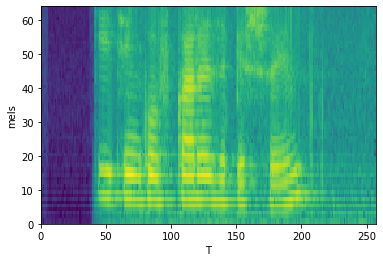

In [55]:
audio, audio_len = open_audio('test_files/test_audio.opus', SAMPLE_RATE)
spectrogram, new_len = compute_log_mel_spectrogram(audio, torch.tensor(audio_len), sample_rate=SAMPLE_RATE)
plt.pcolormesh(spectrogram)
plt.xlabel('T')
plt.ylabel('mels')
plt.show()
Audio(data=audio.numpy(), rate=sample_rate)

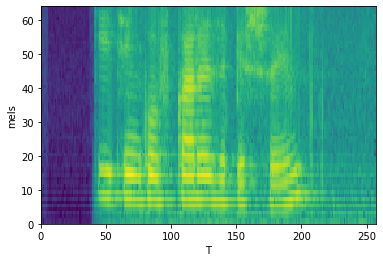

In [56]:
audio, audio_len = open_audio('test_files/test_audio.opus', SAMPLE_RATE)
spectrogram, new_len = compute_log_mel_spectrogram(
    audio, torch.tensor(audio_len), sample_rate=SAMPLE_RATE,
    spectrogram_transform=SpectrogramTransform(freq_mask_param=10, time_mask_param=20)
)
plt.pcolormesh(spectrogram)
plt.xlabel('T')
plt.ylabel('mels')
plt.show()
Audio(data=audio.numpy(), rate=sample_rate)

# Нейронная сеть

Мы подготовили все данные, теперь можно заняться реализацией нейронной сети. Будем реализовывать архитектуру [Deepspeech 2](https://arxiv.org/pdf/1512.02595.pdf) в немного упрощенном виде.


<img src="images/cat_reproduction.jpg" width="400" height="400">


Вот так будет выглядеть архитектура сети:


<img src="images/deepspeech.jpg" width="200" height="150">

In [57]:
import torch.nn as nn
import torch.nn.functional as F

In [58]:
def _calculate_fan(dimentions, conv_params, axis):
    stride = conv_params.get('stride', [1, 1])[axis]
    padding = conv_params.get('padding', [0, 0])[axis]
    kernel_size = conv_params.get('kernel_size')[axis]
    dillation = conv_params.get('dillation', [1, 1])[axis]
    
    return torch.floor((dimentions + 2 * padding - dillation * (kernel_size - 1) - 1) / stride + 1).to(dtype=torch.long)

In [59]:
class Model(torch.nn.Module):
    def __init__(self, num_mel_bins, hidden_size, num_layers, num_tokens):
        super(Model, self).__init__()
        
        self.num_tokens = num_tokens
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.bidirectional = True
        self.num_directions = 2 if self.bidirectional else 1
        
        self.num_mel_bins = num_mel_bins
        
        conv1_params = AttrDict(
            {
                "in_channels": 1,
                "out_channels": 32,
                "kernel_size": [21, 11],
                "stride": [1, 1] 
            })                             
        conv2_params = AttrDict(
            {
                "in_channels": conv1_params['out_channels'],
                "out_channels": 64,
                "kernel_size": [11, 11],
                "stride": [1, 3]                
            }
        )
        
        self.conv1_params = conv1_params
        self.conv2_params = conv2_params
        
        # [batch_size x 1 X num_mel_bins x time] -> [batch_size x conv2.out_channels x fan_num_mel_bins x fan_time]
        self.conv = torch.nn.Sequential(
            ### write your code here ###
        
            # CONV 1
            torch.nn.Conv2d(**self.conv1_params, bias=False),
            # BATCH NORM 1
            torch.nn.BatchNorm2d(num_features=self.conv1_params['out_channels'], momentum=0.9),
            # RELU
            torch.nn.ReLU(inplace=True),
            
            # CONV 2
            torch.nn.Conv2d(**self.conv2_params, bias=False),
            # BATCH NORM 2
            torch.nn.BatchNorm2d(num_features=self.conv2_params['out_channels'], momentum=0.9),
            # RELU
            torch.nn.ReLU(inplace=True),            
        )
        
        # YOUR CODE
        fan_num_mel_bins = _calculate_fan(
            _calculate_fan(torch.tensor(num_mel_bins), conv1_params, axis=0), 
            conv2_params, axis=0
        ).item()
        rnn_input_size = self.conv2_params['out_channels'] * fan_num_mel_bins

        # 4 слоя бидир lstm
        # YOUR CODE
        # [batch_size x fan_time x rnn_input_size] -> [batch_size x fan_time x num_directions * hidden_size], (h_n, c_n)
        self.lstm = torch.nn.LSTM(
            input_size=rnn_input_size, hidden_size=hidden_size, num_layers=self.num_layers,
            bias=True, batch_first=True, bidirectional=self.bidirectional
        )
        
         # YOUR CODE
        # [batch_size x num_directions * hidden_size] -> [batch_size, num_tokens]
        self.output_layer = torch.nn.Linear(self.num_directions * self.hidden_size, self.num_tokens)
    
    def forward(self, inputs, seq_lens, state=None):
        """
            Input shape:
                audio: 3D tensor with shape (batch_size, num_mel_bins, num_timesteps)
                sequence_lengths: 1D tensor with shape (batch_size)
            Returns:
                3D tensor with shape (new_num_timesteps, batch_size, alphabet_len)
                1D tensor with shape (batch_size)
            """
        
        outputs = inputs.unsqueeze(1) # conv2d input should be four-dimensional
        
        ### write your code here ###
        seq_lens = _calculate_fan(_calculate_fan(seq_lens, self.conv1_params, axis=1), self.conv2_params, axis=1)
        
        outputs = self.conv(outputs)

        outputs = self.transpose_and_reshape(outputs)
        outputs, (h_n, c_n) = self.lstm(outputs)

        outputs = self.output_layer(outputs)
        outputs = torch.transpose(outputs, 0, 1)
        outputs = torch.nn.functional.log_softmax(outputs, dim=-1)

        return outputs, seq_lens

    @staticmethod
    def transpose_and_reshape(inputs):
    
        """ This function will be very useful for converting the output of a convolutional layer 
            to the input of a lstm layer
            
            Input shape:
                inputs: 4D tensor with shape (batch_size, num_filters, num_features, num_timesteps)
            Returns:
                3D tensor with shape (batch_size, num_timesteps, new_num_features)
            """
            
        sizes = inputs.size()
                
        # reshape # YOUR CODE
        # (batch_size, num_filters * num_features, num_timesteps)
        outputs = inputs.reshape(inputs.shape[0], inputs.shape[1] * inputs.shape[2], inputs.shape[3])
        # transpose # YOUR CODE
        # (batch_size, num_timesteps, new_num_features)
        outputs = torch.transpose(outputs, 1, 2)
        return outputs
           
    @staticmethod
    def get_new_seq_lens(seq_lens, conv1_kernel_size, conv1_stride, conv2_kernel_size, conv2_stride):
    
        """ Compute sequence_lengths after convolutions
            """
            
        ### write your code here ###
        seq_lens = _calculate_fan(seq_lens, {'kernel_size': [conv1_kernel_size], 'stride': [conv1_stride]}, axis=0)
        seq_lens = _calculate_fan(seq_lens, {'kernel_size': [conv2_kernel_size], 'stride': [conv2_stride]}, axis=0)
        return seq_lens

In [60]:
num_tokens = len(vocab.tokens2indices()) - 1
num_mel_bins = 64
hidden_size= 512
num_layers = 4

In [61]:
model = Model(num_mel_bins=num_mel_bins,
              hidden_size=hidden_size,
              num_layers=num_layers,
              num_tokens=num_tokens)

In [62]:
! pytest tests/test_model.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 5 items                                                              

tests/test_model.py .....                                                [100%]

============================== 5 passed in 2.96s ===============================


Инициализируем модель из чекпоинта, чтобы она обучилась быстрее.

In [63]:
def load_from_ckpt(model, ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])

In [64]:
load_from_ckpt(model, '/home/e.chuykova/data/ckpt.pt')

Тест, чтобы проверить, что код модели корректно написан, модель правильно восстановилась из чекпоинта

In [65]:
audio, audio_len = open_audio('test_files/test_audio.mp3', 8000)
output = model(*compute_log_mel_spectrogram(
    torch.unsqueeze(audio, 0), torch.unsqueeze(torch.tensor([audio_len]), 0), window_step=0.01
))
assert torch.isclose(output[0][0][0][0], torch.tensor(-3.53916406))
assert torch.isclose(output[0][15][0][30], torch.tensor(-3.605963468))

Отправим модель на гпу.

<img src="images/cuda_is_important.jpg" width="400" height="400">


# Обучаем модельку

## Декодинг

In [66]:
from time import time
from tqdm import tqdm_notebook as tqdm
import os

Давайте напишем несколько вспомогательных функций, которые будут нам нужны для обучения модели.

Для начала займемся метриками. Основная метрика - wer (word error rate).

Тут поможет библиотека `editdistance`.

In [67]:
import editdistance

In [68]:
import regex

In [69]:
def calc_wer(predicted_text, gt_text):
    """ Compute wer.
        Inputs:
            predicted_text: str
            gt_text: str
        Returns:
            wer: int
    """
    ### write your code here ###
    words_split_pattern = regex.compile(r'\b\w+\b')
    
    gt_words = regex.findall(words_split_pattern, gt_text)
    predicted_words = regex.findall(words_split_pattern, predicted_text)
    
    if len(gt_words) == len(predicted_words) == 0:
        return 0.0
    if len(gt_words) == 0:
        return 1.0
    wer = editdistance.eval(predicted_words, gt_words) / len(gt_words)
    return wer


def calc_wer_for_batch(list_of_predicted_text, list_of_gt_text):
    """ Compute mean wer for batch.
            Inputs:
                list_of_predicted_text: list
                list_of_gt_text: list
            Returns:int
            
    """
    
    ### write your code here ###
    mean_wer = np.mean([calc_wer(_, __) for _, __ in zip(list_of_predicted_text, list_of_gt_text)])
    return mean_wer

In [70]:
! pytest tests/test_compute_wer.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 7 items                                                              

tests/test_compute_wer.py .......                                        [100%]

============================== 7 passed in 1.79s ===============================


Давайте реализуем greedy decoding. 

Сначала научимся получать greedy trn из выравниваний. Можно использовать `itertools`.

Не забудьте выкинуть лишние пробелы в начале и конце полученного текста!

In [71]:
import itertools

In [72]:
def decode(alignment):
    """ Get text from alignment.
        Inputs:
            alignment: str
        Returns:
            text: srt
    """
    ### write your code here ###
    alignment = regex.sub(r'(\p{L})\1+', r'\1', alignment)
    alignment = alignment.replace('<blank>', '')
    alignment = regex.sub(' +', ' ', alignment)
    text = alignment.strip()
    return text

In [73]:
! pytest tests/test_decode.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 4 items                                                              

tests/test_decode.py ....                                                [100%]

============================== 4 passed in 1.78s ===============================


Получим greedy text из выхода акустической модели (logprobs).

In [74]:
def greedy_decoder(logprobs, logprobs_lens, vocab):
    predictions = []
    
    tokens = torch.argmax(logprobs, dim=-1)
    for idx in range(logprobs.shape[1]):        
        alligmnet_tokens = vocab.lookup_tokens(tokens[:, idx][:logprobs_lens[idx]].detach().cpu().numpy())
        alligmnet = ''.join(alligmnet_tokens)
        hypo = decode(alligmnet)
        predictions += [[(hypo, 1.0)]]
    
    return predictions

In [75]:
from collections import defaultdict

In [76]:
def beam_search_decode(logprobs, logprobs_lens, vocab, beam_size, cutoff_top_n, cutoff_prob, ext_scoring_func, alpha):
    '''
    logprobs: [num_timesteps, alphabet_len]
    '''
    def _beam_search_decode(
        _logprobs, _logprobs_len, 
        vocab, beam_size, cutoff_top_n, cutoff_prob, ext_scoring_func, alpha
    ):
        assert (cutoff_top_n is None) or (cutoff_prob is None)
        if (cutoff_top_n is None) and (cutoff_prob is None):
            cutoff_prob = 1.0

        hypos = set()
        indices2tokens = vocab.indices2tokens()
        probs_b, probs_nb = defaultdict(float), defaultdict(float)

        hypos.add('')
        probs_b[''], probs_nb[''] = 1.0, 0.0
        for t in range(_logprobs_len):
            hypos_new = set()
            probs_b_new, probs_nb_new = defaultdict(float), defaultdict(float)

            probs_t = torch.exp(_logprobs[t]).detach().cpu()
            decreace_idxs = torch.argsort(-probs_t).detach().cpu().numpy()
            if cutoff_prob is not None:
                cond_idxs = torch.where(torch.cumsum(probs_t[decreace_idxs], dim=0) > cutoff_prob)[0]
                if len(cond_idxs) == 0:
                    cutoff_top_n = len(decreace_idxs)
                else:
                    cutoff_top_n = cond_idxs[0].item()
                if cutoff_top_n == 0:
                    cutoff_top_n = 1

            for l in hypos:
                for c_idx in decreace_idxs[:cutoff_top_n]:
                    c, c_prob = indices2tokens[c_idx], probs_t[c_idx]

                    if c == '<blank>':
                        probs_b_new[l] += c_prob * (probs_b[l] + probs_nb[l])
                    else:
                        l_end = l[-1] if len(l) > 0 else ''
                        l_plus = l + c
                        if c == l_end:
                            probs_nb_new[l] += c_prob * probs_nb[l]
                            probs_nb_new[l_plus] += c_prob * probs_b[l]
                        elif c == ' ':
                            if ext_scoring_func is None:
                                p_W = 1.0
                            else:
                                p_W = ext_scoring_func(l)
                            probs_b_new[l_plus] += np.power(p_W, alpha) * c_prob * (probs_b[l] + probs_nb[l])
                        else:
                            probs_nb_new[l_plus] += c_prob * (probs_b[l] + probs_nb[l])
                        hypos_new.add(l_plus)                                        
                hypos_new.add(l)


            hypos_new = list(
                sorted(hypos_new, key=lambda hypo: probs_b_new[hypo] + probs_nb_new[hypo], reverse=True)
            )[:min(beam_size, len(hypos_new))]

            hypos, probs_b, probs_nb = hypos_new, probs_b_new, probs_nb_new

        return sorted(
            [(hypo, probs_b_new[hypo] + probs_nb_new[hypo]) for hypo in hypos],
            key=lambda key_value: key_value[1], reverse=True
        )
    
    predictions = []
    for idx in range(logprobs.shape[1]):
        hypos =  _beam_search_decode(
            logprobs[:, idx], logprobs_lens[idx],
            vocab=vocab, beam_size=beam_size,
            cutoff_top_n=cutoff_top_n, cutoff_prob=cutoff_prob,
            ext_scoring_func=ext_scoring_func, alpha=alpha
        )
        predictions.append(hypos)

    return predictions

In [77]:
from ctcdecode import CTCBeamDecoder

In [78]:
def fast_beam_search_decode(
    logprobs, logprobs_lens, vocab, beam_size, cutoff_top_n, cutoff_prob, ext_scoring_func, alpha, beta, num_processes
):
    labels = ''.join(vocab.indices2tokens()).replace('<blank>', '_').replace('<unk>', '')
    decoder = CTCBeamDecoder(
        labels=labels, blank_id=blank_index,
        cutoff_top_n=cutoff_top_n, cutoff_prob=cutoff_prob, beam_width=beam_size,
        model_path=ext_scoring_func, alpha=alpha, beta=beta,
        num_processes=num_processes,
        log_probs_input=False
    )
    probs = torch.exp(logprobs)
    beam_results, beam_scores, timesteps, out_lens = decoder.decode(torch.transpose(probs, 0, 1), logprobs_lens)
    beam_probas = torch.exp(-beam_scores)
    
    predictions = []
    for idx in range(beam_results.shape[0]):
        beam = []
        for jdx in range(beam_results.shape[1]):
            hypo = ''.join(vocab.lookup_tokens(beam_results[idx, jdx, :out_lens[idx, jdx]].tolist()))
            hypo_score = beam_probas[idx, jdx]
            beam.append((hypo, hypo_score))
        predictions.append(beam)
        
    return predictions

In [79]:
def get_prediction(logprobs, logprobs_lens, vocab, decoder=greedy_decoder, decoder_kwargs=None):
    """ Compute greedy text from loglikes.
            Input shape:
                logprobs: 3D tensor with shape (num_timesteps, batch_size, alphabet_len)
                logprobs_lens: 1D tensor with shape (batch_size)
            Returns:
                list of texts with len (batch_size)
    """
    if decoder_kwargs is None:
        decoder_kwargs = dict()
        
    predictions = decoder(logprobs=logprobs, logprobs_lens=logprobs_lens, vocab=vocab, **decoder_kwargs)
    predictions = [sorted(hypos, key=lambda key_value: key_value[1], reverse=True)[0][0] for hypos in predictions]

    return predictions

In [80]:
if os.path.exists('./models/1/epoch_6.pt'):
    load_from_ckpt(model, './models/1/epoch_6.pt')

In [80]:
# batch = next(iter(common_voice_val_dataloader))
batch = next(iter(open_stt_test_dataloader))
# batch = next(iter(ls_train_dataloader))

log_mel_spectrogram, seq_lens = compute_log_mel_spectrogram(batch['audios'], batch['audio_lens'], sample_rate=SAMPLE_RATE)
logprobs, seq_lens = model(log_mel_spectrogram, seq_lens)

In [81]:
print(get_prediction(logprobs=logprobs, logprobs_lens=seq_lens, vocab=vocab, decoder=greedy_decoder))

['савиети', 'егиепвнст', 'дловникомы', 'сельнности', 'прерь', 'шестляет', 'свади', 'ете', 'на оноец', 'шинолет', 'мреканцид', 'ло шире', 'честост', 'серьзны', 'октору', 'ш', 'вобирай', 'ровям мерика', 'что', 'мо его твит', 'личетно', 'оторый', 'ватьницов', 'члоену', 'никоотих', 'тульбы', 'во', 'крорествпи', 'нывестит', 'вкорание', 'лучея', 'рхоит', 'вдруг', 'вольнорек', 'равосстви', 'полимер', 'вишкаторах', 'нузнать', 'пордвлам мени', 'рмажены равершить', 'работыт то нее', 'начинает потом', 'ран', 'развильна', 'вго', 'дурова', 'ае что нея', 'бления', 'кк мождно', 'ровонесказано', 'долуже', 'каккумсь', 'осремена', 'брограмасобы', 'нужденно', 'несобмненно', 'они главе', 'скант непро', 'се гадости', 'нажиттк', 'окторишеть', 'это дже', 'даестпочетае', 'оватие си зравнени', 'атисит', 'истестеоно', 'раждан', 'ользвотелии', 'удебгы харкстов', 'нискем тот', 'злишении', 'на гоужрелов', 'решет', 'нет твяжитюься', 'разброс', 'норлезодвть', 'том честле', 'вот ет вен', 'стомы нила там', 'пынимю', '

In [82]:
beam_kwargs = {'beam_size': 10, 'cutoff_top_n': 1, 'cutoff_prob': None, 'ext_scoring_func': None, 'alpha': 1.0}

In [83]:
print(get_prediction(
    logprobs=logprobs, logprobs_lens=seq_lens, vocab=vocab, 
    decoder=beam_search_decode, decoder_kwargs=beam_kwargs
))

['савиети', 'егиепвнст', 'дловникомы', 'сельнности', 'прерь', 'шестляет', 'свади', 'ете', 'на  оноец', 'шинолет', 'мреканцид', 'ло  шире', 'честост', '  серьзны', ' октору', 'ш', 'вобирай', 'ровям мерика', '  что', 'мо  его  твит', 'личетно', 'оторый', 'ватьницов', 'члоену', '  никоотих', 'тульбы', 'во', 'крорествпи', 'нывестит', '  вкорание', 'лучея', 'рхоит', 'вдруг', 'вольнорек', ' равосстви', 'полимер', 'вишкаторах', 'нузнать', 'пордвлам мени', 'рмажены  равершить', 'работыт  то  нее', 'начинает  потом', 'ран', 'развильна', 'вго', ' дурова', '  ае  что  нея', 'бления', 'кк  мождно', ' ровонесказано', 'долуже', 'каккумсь', 'осремена', 'брограмасобы', 'нужденно', 'несобмненно', '  они  главе', ' скант  непро', 'се  гадости', 'нажиттк', 'окторишеть', ' это  дже', 'даестпочетае', 'оватие си зравнени', 'атисит', 'истестеоно', 'раждан', 'ользвотелии', 'удебгы  харкстов', 'нискем  тот', 'злишении', 'на  гоужрелов', 'решет', 'нет  твяжитюься', ' разброс', 'норлезодвть', 'том  честле', 'вот

In [84]:
fast_beam_kwargs = {
    'beam_size': 10, 'cutoff_top_n': 1, 'cutoff_prob': 1.0, 
    'ext_scoring_func': None, 'alpha': 1.0, 'beta': 0.0, 'num_processes': 16
}

In [85]:
print(get_prediction(
    logprobs=logprobs, logprobs_lens=seq_lens, vocab=vocab, 
    decoder=fast_beam_search_decode, decoder_kwargs=fast_beam_kwargs
))

['савиети', 'егиепвнст', 'дловникомы', 'сельнности', 'прерь', 'шестляет', 'свади', 'ете', 'на оноец', 'шинолет', 'мреканцид', 'ло шире', 'честост', ' серьзны', ' октору', '', 'вобирай', 'ровям мерика', ' что', 'мо его твит', 'личетно', 'оторый', 'ватьницов', 'члоену', ' никоотих', 'тульбы', '', 'крорествпи', 'нывестит', ' вкорание', 'лучея', 'рхоит', 'вдруг', 'вольнорек', ' равосстви', 'полимер', 'вишкаторах', 'нузнать', 'пордвлам мени', 'рмажены равершить', 'работыт то нее', 'начинает потом', 'ран', 'развильна', 'вго', ' дурова', ' ае что нея', 'бления', 'кк мождно', ' ровонесказано', 'долуже', 'каккумсь', 'осремена', 'брограмасобы', 'нужденно', 'несобмненно', ' они главе', ' скант непро', 'се гадости', 'нажиттк', 'окторишеть', ' это дже', 'даестпочетае', 'оватие си зравнени', 'атисит', 'истестеоно', 'раждан', 'ользвотелии', 'удебгы харкстов', 'нискем тот', 'злишении', 'на гоужрелов', 'решет', 'нет твяжитюься', ' разброс', 'норлезодвть', 'том честле', 'вот ет вен', 'стомы нила там', '

In [86]:
! pytest tests/test_get_prediction.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mnakhodnov/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_get_prediction.py .                                           [100%]

============================== 1 passed in 1.78s ===============================


В этой функции надо из сырых данных, извлеченных из датасета, получить спектрограмму, прогнать через модель, посчитать средний лосс и wer для батча, list с текстами предсказанных гипотез для батча.

In [81]:
def get_model_results(
    model, audios, audio_lens, tokens, texts, text_lens, 
    vocab, loss_fn, decoder, decoder_kwargs
):
    global _idx
    """ get mean loss, mean wer and prediction list for batch
        Returns:
            loss: int
            wer: int
            prediction: list of str
            
    """
    ### write your code here ###
    log_mel_spectrogram, seq_lens = compute_log_mel_spectrogram(audios, audio_lens, sample_rate=SAMPLE_RATE)
    logprobs, seq_lens = model(log_mel_spectrogram, seq_lens)
    loss = loss_fn(logprobs, tokens, seq_lens, text_lens)
    
    with torch.no_grad():
        predictions = get_prediction(logprobs, seq_lens, vocab, decoder=decoder, decoder_kwargs=decoder_kwargs)
        wer = calc_wer_for_batch(predictions, texts)
    return loss, wer, predictions

Для удобства будем логировать метрики в [tensorboard](https://pytorch.org/docs/stable/tensorboard.html).

In [82]:
from torch.utils.tensorboard import SummaryWriter

In [83]:
class TensorboardLogger:
    def __init__(self, tensorboard_path):
        self.writer = SummaryWriter(tensorboard_path)

    def log(self, step, loss, wer, mode):
        ### write your code here ###
        
        # add loss to tb 
        # add wer to tb 
        self.writer.add_scalar(f'wer/{mode}', wer, global_step=step)
        self.writer.add_scalar(f'loss/{mode}', loss, global_step=step)

    def log_text(self, step, pred_texts, gt_texts, mode):
        
        ### write your code here ###
        
        for pred_text in pred_texts:
            # add pred text to tb 
            self.writer.add_text(f'predict/{mode}', pred_text, global_step=step)
            
        for gt_text in gt_texts:
            # add gt text to tb 
            self.writer.add_text(f'ground truth/{mode}', gt_text, global_step=step)
      
    def close(self):
        self.writer.close()

Теперь можем собрать функции в train loop. 

## Training parameters

In [84]:
def validate(model, dataloader, vocab, loss_fn, decoder, decoder_kwargs):
    loss, wer = 0.0, 0.0
    with torch.no_grad():
        for batch in tqdm(dataloader, total=len(dataloader)):
            batch = {
                key: value.to(device=device) if isinstance(value, torch.Tensor) else value for key, value in batch.items()
            }
            loss_batch, wer_batch, prediction = get_model_results(
                model, batch["audios"], batch["audio_lens"],
                batch["tokens"], batch["texts"], batch["text_lens"], vocab, loss_fn,
                decoder=decoder, decoder_kwargs=decoder_kwargs
            )

            loss += loss_batch.item() * batch['audio_lens'].shape[0]
            wer += wer_batch * batch['audio_lens'].shape[0]

        loss /= len(dataloader.dataset)
        wer /= len(dataloader.dataset)
    return loss, wer

In [85]:
def training(
    model, optimizer, loss_fn, num_epochs, 
    train_dataloader, val_dataloaders, log_every_n_batch, model_dir,
    vocab, beam_kwargs
):

    logger = TensorboardLogger(model_dir)

    for epoch in range(num_epochs):
        start_time = time()
        train_loss, train_wer = 0, 0
        
        if isinstance(train_dataloader, list):
            train_dataloader, train_dataloader_name = train_dataloader
        else:
            train_dataloader, train_dataloader_name = train_dataloader, 'train'
        
        model.train(True)    
        for iteration, batch in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
            batch = {
                key: value.to(device=device) if isinstance(value, torch.Tensor) else value for key, value in batch.items()
            }
            loss, wer, prediction = get_model_results(
                model, batch["audios"], batch["audio_lens"], 
                batch["tokens"], batch["texts"], batch["text_lens"], vocab, loss_fn,
                decoder=greedy_decoder, decoder_kwargs=dict()
            )

            # optimizer step
            ### write your code here ###
            optimizer.zero_grad()
            loss.backward()

            gradient_norm = torch.sqrt(sum((torch.square(torch.norm(p.grad)) for p in model.parameters()))).item()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1000.0, norm_type=2.0)
            gradient_norm_clipped = torch.sqrt(sum((torch.square(torch.norm(p.grad)) for p in model.parameters()))).item()
          
            optimizer.step()

            train_loss += loss.item() * batch['audio_lens'].shape[0]
            train_wer += wer * batch['audio_lens'].shape[0]

            step = len(train_dataloader) * epoch + iteration

            logger.writer.add_scalar(f'grad_norm/non_clipped', gradient_norm, global_step=step)
            logger.writer.add_scalar(f'grad_norm/clipped', gradient_norm_clipped, global_step=step)
            if step % log_every_n_batch == 0:
                logger.log(step, loss, wer, train_dataloader_name)
                logger.log_text(step, prediction, batch["texts"], train_dataloader_name)
                
            del batch, loss, wer, prediction
        train_loss /= len(train_dataloader.dataset)
        train_wer /= len(train_dataloader.dataset)
        
        model.train(False)      
        val_losses, val_wers = dict(), dict()
        for name, val_dataloader in val_dataloaders.items():
            val_loss, val_wer = validate(
                model=model, dataloader=val_dataloader, vocab=vocab, loss_fn=loss_fn,
                decoder=fast_beam_search_decode, decoder_kwargs=beam_kwargs
            )
            val_wers[name] = val_wer
            val_losses[name] = val_loss
            
            logger.log(step, val_loss, val_wer, f'{name}')
            logger.log_text(step, prediction, batch["texts"], f"{name}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, os.path.join(model_dir, f'epoch_{epoch}.pt'))

        common_voice_val_wer, common_voice_val_loss = val_wers['common_voice/val'], val_losses['common_voice/val']
        print(
            f'\nEpoch {epoch + 1} of {num_epochs} took {time() - start_time}s, ' + \
            f'train loss: {train_loss}, val loss: {common_voice_val_loss}, ' + \
            f'train wer: {train_wer}, val wer: {common_voice_val_wer}'
        )

    logger.close()
    print("Finished!")

## Train LM model for beam search

In [86]:
with open('/data/mnakhodnov/language_data/common_voice/train.txt', 'w') as lm_data_file:
    for text in common_voice_test_dataset.data['text']:
        lm_data_file.write(text + '\n')

In [87]:
def preprocess_for_lm(document):
    document = document.lower()
    document = regex.sub(r'\P{Cyrillic}', ' ', document)
    document = regex.sub(' +', ' ', document)
    return document

In [ ]:
in_path = '/data/mnakhodnov/language_data/cc100/xaa'
with open(in_path, 'r') as data_file:
    with open(in_path + '.processed', 'w') as lm_data_file:
        n_documnets, current_document = 0, []
        for idx, line in enumerate(data_file):
            line = line.strip()
            if line == '':
                # End of document
                n_documnets += 1
                current_document = preprocess_for_lm(' '.join(current_document))
                if current_document != '':
                    lm_data_file.write(current_document + '\n')
                current_document = []
            else:
                # New paragraph in document
                current_document.append(line)

In [88]:
kenlm_bin_path = '/home/mnakhodnov/kenlm/build/bin'

# kenlm_data_path = '/data/mnakhodnov/language_data/cc100/xaa.processed.4'
kenlm_data_path = '/data/mnakhodnov/language_data/common_voice/train.txt'
kenlm_arpa_path, kenlm_binary_path = kenlm_data_path + '.arpa', kenlm_data_path + '.binary'

In [119]:
! $kenlm_bin_path/lmplz -o 5 -S 80% -T /data/mnakhodnov/language_data/tmp <$kenlm_data_path > $kenlm_arpa_path

=== 1/5 Counting and sorting n-grams ===
Reading /data/mnakhodnov/language_data/cc100/xaa.processed.4
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 331074 types 51186
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:614232 2:20103364608 3:37693812736 4:60310097920 5:87952228352
Statistics:
1 51186 D1=0.652332 D2=1.10365 D3+=1.4757
2 227275 D1=0.871749 D2=1.19501 D3+=1.48887
3 304511 D1=0.960632 D2=1.38513 D3+=1.60137
4 319924 D1=0.987147 D2=1.59434 D3+=1.60474
5 323468 D1=0.977654 D2=1.68627 D3+=1.24524
Memory estimate for binary LM:
type       kB
probing 26947 assuming -p 1.5
probing 32137 assuming -r models -p 1.5
trie    13244 without quantization
trie     7456 assuming -q 8 -b 8 quantization 
trie    12008 assuming -a 22 array pointer compression
trie     6220 assuming -a 22 -q 8 -b 8 array point

In [120]:
! $kenlm_bin_path/build_binary $kenlm_arpa_path $kenlm_binary_path

Reading /data/mnakhodnov/language_data/cc100/xaa.processed.4.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
SUCCESS


In [89]:
# load_from_ckpt(model, './models/2/epoch_6.pt')

In [90]:
beam_kwargs = {
    'beam_size': 10, 'cutoff_top_n': 5, 'cutoff_prob': None, 
    'ext_scoring_func': None, 'alpha': 1.0
}
fast_beam_kwargs = {
    'beam_size': 10, 'cutoff_top_n': 5, 'cutoff_prob': 1.0, 
    'ext_scoring_func': kenlm_binary_path, 'alpha': 1.0, 'beta': 0.3, 'num_processes': 32
}

In [210]:
model.eval()
loss, wer = validate(
    model, common_voice_val_dataloader, vocab, loss_fn,
#     decoder=greedy_decoder, decoder_kwargs={}
#     decoder=beam_search_decode, decoder_kwargs=beam_kwargs  
    decoder=fast_beam_search_decode, decoder_kwargs=fast_beam_kwargs
)
model.train()

print(f'Loss: {loss}, WER: {wer}')

# greedy -> Loss: 0.2857444478869438, WER: 0.3258212143412143
# fast_beam_search -> Loss: 0.2857444478869438, WER: 0.3172471955821956
# fast_beam_search + LM (1.0, 0.0) -> Loss: 0.2857444478869438, WER: 0.26591688394938395
# fast_beam_search + LM (1.0, 0.3) -> Loss: 0.2857444478869438, WER: 0.2645809271284272

## And for now we finally train model

In [91]:
num_epochs = 7
model_dir = 'models/4'
log_every_n_batch = 10

model = Model(
    num_mel_bins=num_mel_bins,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_tokens=num_tokens
)
load_from_ckpt(model, '/home/e.chuykova/data/ckpt.pt')
# load_from_ckpt(model, '/home/mnakhodnov/sirius-stt/models/2/epoch_5.pt')
model = model.to(device=device)

In [92]:
learning_rate = 2e-4
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CTCLoss(blank=blank_index, reduction='mean')

Про ctc loss очень хорошо написано [тут](https://distill.pub/2017/ctc/). А [это](https://www.cs.toronto.edu/~graves/icml_2006.pdf) исходная статья.

Если не используете перемешивание батчей (шафл), то при подборе batch size обратите внимание, что данные отсортированы (обучение будет замедляться с увеличением длины аудио).

In [103]:
# ls_train_dataloader.sampler.epoch = 0
# open_stt_train_dataloader.sampler.epoch = 0
# common_voice_train_dataloader.sampler.epoch = 0

In [ ]:
num_epochs = 100

training(
    model=model, optimizer=opt, loss_fn=loss_fn, num_epochs=num_epochs, 
#     train_dataloader=[common_voice_train_dataloader, 'common_voice/train'],
#     train_dataloader=[ls_train_dataloader, 'libre_speech/train'],
    train_dataloader=[open_stt_train_dataloader, 'open_stt/train'],
    val_dataloaders={
        'open_stt/test': ls_test_dataloader,
        'libre_speech/dev': ls_dev_dataloader,
        'libre_speech/test': ls_test_dataloader,
        'common_voice/val': common_voice_val_dataloader,
    }, log_every_n_batch=log_every_n_batch, model_dir=model_dir, vocab=vocab,
    beam_kwargs=fast_beam_kwargs
)

  0%|          | 0/4282 [00:00<?, ?it/s]

<img src="images/training.jpeg" width="400" height="400">


После того, как напишете весь код и запустите обучение вашей первой модели, примерно после 5-6 эпох качество модели достигнет 30-35% WER.

# Как можно улучшить полученные результаты

<img src="images/pronunciation_or_not.jpg" width="400" height="400">

Далее описаны несколько способов, которые могут помочь улучшить качество. Потенциальный прирост обозначим ★, чем больше звездочек, тем более хорошее улучшение качества можно ожидать.

## Beam search ★★

На лекции обсуждали, что beam search помогает достичь более хорошего качества, чем greedy декодирование.

Изучить алгоритм можно [тут](https://medium.com/corti-ai/ctc-networks-and-language-models-prefix-beam-search-explained-c11d1ee23306) и [тут](https://drive.google.com/viewerng/viewer?url=https://arxiv.org/pdf/1408.2873.pdf)

Код для beam search посмотреть [тут](https://github.com/PaddlePaddle/DeepSpeech/blob/master/decoders/decoders_deprecated.py). (Отредактировать при необходимости )

## Внешняя языковая модель ★★★


Внешняя языковая модель позволяет улучшить качество, т.к. убирает условную независимость соседних символов, которая свойственна ctc лоссу.

Этот пункт состоит из двух этапов: сначала надо обучить языковую модель, затем встроить ее в beam search.

#### Обучение

Для обучения n-gram языковой модели можно использовать фреймворк kenlm.
Документация: 
* https://kheafield.com/code/kenlm/
* https://github.com/kpu/kenlm

Модель сначала строится в формате arpa, затем ее лучше перевести в формат trie. Вызывать полученную модель можно через питон [ссылка](https://github.com/kpu/kenlm#python-module)


#### Данные

Для обучения модели конечно нужны данные :) Тут есть варианты:

1. Можно обучить маленькую языковую модель на текстах из акустических обучающих данных (из трейна!).

минусы: этих данных мало

плюсы: домен остается таким же

2. Можно взять внешние данные, например, [отсюда](http://data.statmt.org/cc-100/). (46G).

минусы: тексты из другого (произвольного) домена

плюсы: данных много

При необходимости, данные надо предобработать - привести к нижнему регистру, разделить на предложения. Убрать предложения, которые содержат символы не из русского алфавита 


#### Внедрение в beam search

В разделе про beam search есть ссылки на алгоритм.

Можно использовать аргумент `ext_scoring_func` [тут](https://github.com/PaddlePaddle/DeepSpeech/blob/master/decoders/decoders_deprecated.py#L47).

Пример скорера можно найти [тут](https://github.com/PaddlePaddle/DeepSpeech/blob/master/decoders/scorer_deprecated.py)

## Аугментации ★


Позволяют искусственно увеличь размер обучающей выборки, сделать его более разнообразным.

### Аугментации аудио 

Применяются к аудиосигналу. Аугментации обычно реализуются через [sox](https://ru.wikipedia.org/wiki/SoX_(%D0%BF%D1%80%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B0)). [Тут](http://sox.sourceforge.net/sox.html#EFFECTS) можно посмотротреть полный список sox эффектов с описанием. 

Полный список sox эффектов, доступных в torchaudio, можно посмотреть [тут](https://github.com/pytorch/audio/issues/260).

Эффекты можно комбинировать.

Внимание!

* Аугментации надо применять очень аккуратно (!) - слишком сильные аугментации только ухудшат качество. Лучше применять аугментации с некоторой вероятностью.
* Применять **только на обучающую выборку, не на валидацию!**
* Некоторые аугментации меняют sample rate и длину аудио.
* Можно применять не открывая предварительно аудиофайл [ссылка](https://pytorch.org/audio/stable/sox_effects.html#applying-effects-on-file).


Примеры:

In [ ]:
def augment_audio(audio, sample_rate, effects):
    
    effects = [effects, ['rate', '8000']]

    augmented_audio, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
        torch.unsqueeze(audio, 0),
        sample_rate=sample_rate,
        effects=effects,
        channels_first=True)
    
    return augmented_audio

In [ ]:
sample_rate = 8000
audio, audio_len = open_audio('test_files/test_audio.mp3', sample_rate)
Audio(data=audio.numpy(), rate=sample_rate)

In [ ]:
augmented_audio = augment_audio(audio, sample_rate, ['treble', '20'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

In [ ]:
augmented_audio = augment_audio(audio, sample_rate, ['bass', '20'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

In [ ]:
augmented_audio = augment_audio(audio, sample_rate, ['pitch', '400'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

In [ ]:
augmented_audio = augment_audio(audio, sample_rate, ['speed', '1.5'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

In [ ]:
augmented_audio = augment_audio(audio, sample_rate, ['tempo', '1.5'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

### Аугментации спектрограммы

[SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition](https://arxiv.org/pdf/1904.08779.pdf)

Методов [Frequency masking](https://pytorch.org/audio/stable/transforms.html#frequencymasking) и [Time masking](https://pytorch.org/audio/stable/transforms.html#timemasking) должно быть достаточно.

# Что еще можно попробовать: 

1. Поэкспериментировать с learning rate, оптимайзером (например, взять SGD). Можно добавить [lr decay](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ExponentialLR) ★
2. Поэкспериментировать с нейронной сетью и восттановлением из чекпоинта. Например, зафиксировать предобученные слои и дообучить остальные, потом с маленьким learning rate дообучить всю модель. ★
3. Добавить новые слои в нейронную сеть. ★★
4. Использовать больше данных. ★★★
<img src="images/more_data.jpg" width="400" height="400">

В этом случае для ускорения можно запустить распределенное обучение на нескольких gpu с помощью [horovod](https://github.com/horovod/horovod). Данные можно взять тут:

* [open_stt](https://github.com/snakers4/open_stt) (до 2.5 TB данных!)
* [Russian LibriSpeech](https://openslr.org/96/) (9 GB данных)


5\. Не использовать чекпоинт и обучить свою сеть :) ★ (потребуется больше данных!)

6\. Shallow fusion - можно обучить дополнительную языковую модель и использовать в качестве рескорера 
[ссылка](https://arxiv.org/pdf/1503.03535.pdf). ★

7\. Реализовать перемешивание батчей. ★
